In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib ipympl

import sys
sys.path.append('/Users/austin/Documents/GitHub/atomai')
import atomai as aoi
import torch

## Load, weight, onehot data

In [3]:
image_dim = 512
dataset = np.load('../PdSeM_train_test_512_blur_2class.npz')
images = dataset['X_train'].reshape(-1,1,image_dim,image_dim)
labels = dataset['y_train'].reshape(-1,image_dim,image_dim)
images_test = dataset['X_test'].reshape(-1,1,image_dim,image_dim)
labels_test = dataset['y_test'].reshape(-1,image_dim,image_dim)

#import pyTEMlib.file_tools as ft
#expdata = ft.open_file('drive/MyDrive/Colab Notebooks/data_SBIL9XP6LJEU2RLNL88IO78WI.ndata')['Channel_000']
#expdata = np.array(expdata)

In [4]:
print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)

(592, 1, 512, 512) (592, 512, 512)
(208, 1, 512, 512) (208, 512, 512)


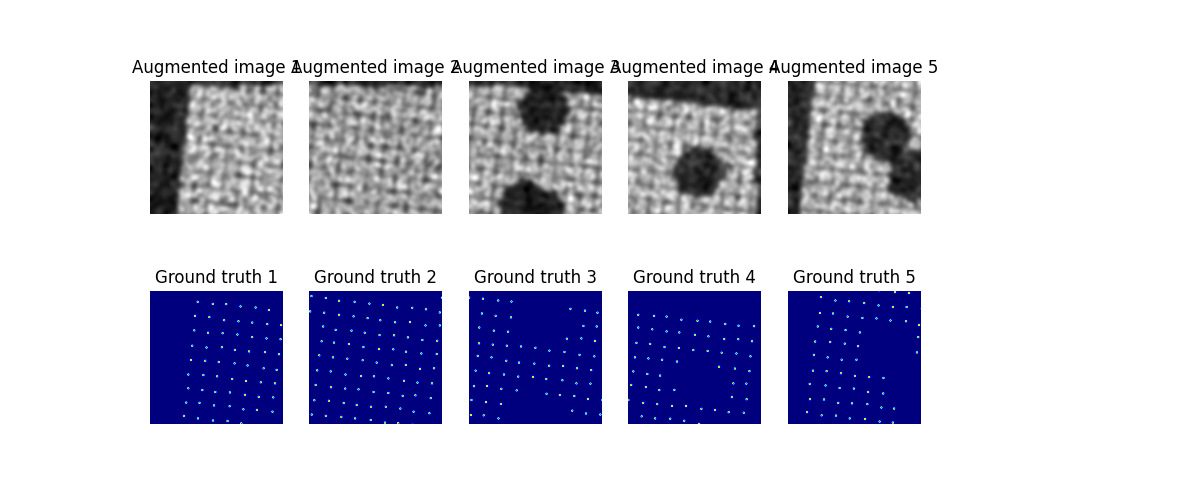

In [12]:
n = 5 # number of images to plot

n = n + 1
fig = plt.figure( figsize=(12, 5))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i))
    ax.grid(alpha = 0.5)
    ax.set_axis_off()
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i-1], interpolation='Gaussian', cmap='jet')
    ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)
    ax.set_axis_off()